# Model misspecification detection

In [1]:
import hypothesis

# hypothesis.disable_gpu()

In [2]:
import torch
import plotting
import numpy as np
import matplotlib
import glob
import matplotlib.pyplot as plt
import warnings
import os

from matplotlib import rc
from util import load_ratio_estimator
from util import download
from util import load
from hypothesis.diagnostic import DensityDiagnostic
from util import MarginalizedAgePrior as Prior
from plotting import compute_1d_pdf
from plotting import compute_2d_pdf
from plotting import compute_1d_lr
from plotting import compute_2d_lr
from plotting import plot_1d_confidence_levels
from plotting import plot_1d_contours
from hypothesis.visualization.util import make_square

warnings.filterwarnings('ignore')

**Note**: This notebook will autodetect the presence of a GPU. Disabling the usage of the GPU can be done by uncommenting `hypothesis.disable_gpu()` and restarting the notebook.

## Download the required data dependencies

In [3]:
# Download (part-of) the presimulated test data (about 47 MB)
# https://drive.google.com/file/d/1Z3d2pZXzcyR9nAj3kZBTTevlKugiHCnO/view?usp=sharing

if not os.path.exists("data.tar.gz"):
    download("1Z3d2pZXzcyR9nAj3kZBTTevlKugiHCnO", destination="data.tar.gz")
    !tar -zxf data.tar.gz # Unpack

ages = np.load("ages.npy")
masses = np.load("masses.npy")
densities = np.load("density-contrasts-cut-noised.npy")
phi = np.load("phi-cut.npy")

print("Completed!")

Completed!


In [4]:
# Download all pre-trained models (about 3.1 GB)
# https://drive.google.com/file/d/1W0WvrdtVvyTu24FBtvtvQz1pKJxMBO_w/view?usp=sharing

if not os.path.exists("models.tar.gz"):
    download("1W0WvrdtVvyTu24FBtvtvQz1pKJxMBO_w", destination="models.tar.gz")
    !tar -zxf models.tar.gz # Unpack
print("Completed!")

Completed!


## Utilities

In [5]:
@torch.no_grad()
def integrate(ratio_estimator, observable):
    prior = Prior()
    space = [[prior.low.item(), prior.high.item()]]
    diagnostic = DensityDiagnostic(space)
    observable = observable.view(1, -1)
    density = observable.to(hypothesis.accelerator)
    # Define the pdf function for integration
    def pdf(mass):
        mass = torch.tensor(mass).view(1, 1).float()
        mass = mass.to(hypothesis.accelerator)
        log_posterior = prior.log_prob(mass).item() + ratio_estimator.log_ratio(inputs=mass, outputs=density)

        return log_posterior.exp().item()
    diagnostic.test(pdf) # Execute the integration

    return diagnostic.areas[0]

## Demonstration

The proper probability distribution diagnostic checks whether the ratio estimator $r(x\vert\vartheta)$ models a proper probability distribution in conjunction with the prior. That is, the diagnostic verifies
$$
\int_\vartheta p(\vartheta)r(x\vert\vartheta)~d\vartheta = 1~\forall x,
$$
where $x$ are synthethic observables produced by the simulation model.

To demonstrate that this is effectively the case, let's load a pretrained ratio estimator based on the ResNet-50 architecture

In [6]:
# Load the pretrained ratio estimator
ratio_estimator = load("resnet-50")

and a random observable from the a small test dataset

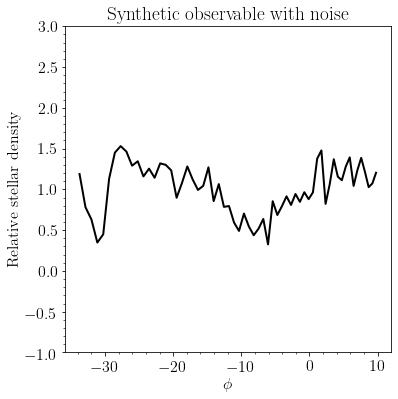

In [7]:
# Pick a random synthetic observable
index = np.random.randint(0, len(ages))
groundtruth_age = torch.from_numpy(ages[index])
groundtruth_mass = torch.from_numpy(masses[index])
stellar_density = torch.from_numpy(densities[index]).float().view(1, -1)

# Show how the observable looks like
figure = plt.figure(figsize=(6, 6))
plt.title("Synthetic observable with noise")
plt.plot(phi, stellar_density.view(-1).numpy(), lw=2, color="black")
plt.xlabel(r"$\phi$")
plt.minorticks_on()
plt.ylabel("Relative stellar density")
plt.ylim([-1, 3])
make_square(plt.gca())
plt.show()

Lets now integrate the area under the modelled posterior density function.

In [8]:
integrated_area = integrate(ratio_estimator, stellar_density) # This might take some time

integrated_area

0.9883290455111579

The approximated integrated area approximates 1 and therefore suggests that the probability density implicitelly modelled through the ratio estimator is valid (although this should be repeated for all observables $x$). With valid we imply that the ratio estimator models a proper probability density. The result does not necessarily say anything about the correctness about the approximation.

Lets see what the result is whenever we apply the diagnostic to an out of distribution sample. Since stellar densities cannot possibly take the shape of square waves, we'll evaluate the diagnostic on such an observable. The generated square wave is thus effectively an out of distribution sample.

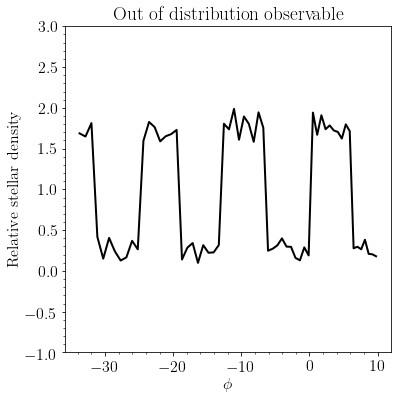

In [9]:
import scipy.signal

# You could play with this however you like, see if the result changes!
stellar_density = scipy.signal.square(phi * 0.5, duty=0.5) * 0.75 + 1 + np.random.randn(len(phi)) * 0.1
# stellar_density = np.sin(phi * 0.2 + 15) * 0.1 + 1

# The diagnostic expects PyTorch tensors as a single-precision float.
stellar_density = torch.from_numpy(stellar_density).float()

# Show how the observable looks like
figure = plt.figure(figsize=(6, 6))
plt.title("Out of distribution observable")
plt.plot(phi, stellar_density.view(-1).numpy(), lw=2, color="black")
plt.xlabel(r"$\phi$")
plt.minorticks_on()
plt.ylabel("Relative stellar density")
plt.ylim([-1, 3])
make_square(plt.gca())
plt.show()

In [10]:
integrated_area = integrate(ratio_estimator, stellar_density) # This might take some time

integrated_area

0.8917660969089412

Clearly, the integrated area does not (subjectively) approximate 1 and thus confirms our hypothesis that the diagnostic could be used to detect model misspecification whenever the ratio estimator correctly models probability densities for all synthetic observables produced by the assumed simulation model.

However, how should we determine the cut-off point? That is, how do we indicate whenever an observable is an out of distribution sample? Let us consider the figure below for a moment.

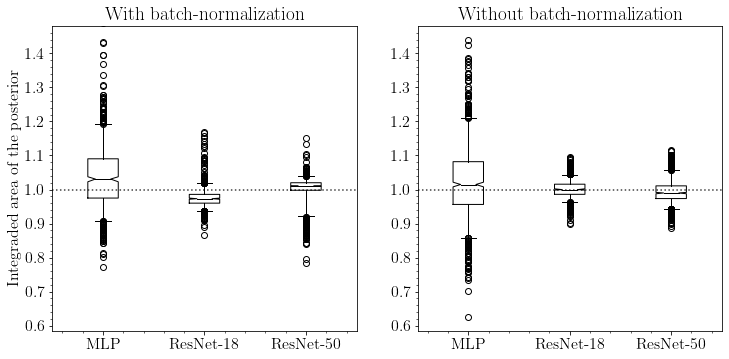

If we would take the whiskers as as the thresholds for the out of distribution detection for *observed* data (not simulated), we would have 0.945 and 1.05 as thresholds.

In [11]:
def is_out_of_distribution(observable):
    integrated_area = integrate(ratio_estimator, observable)
    
    not_passed = integrated_area < 0.945 or integrated_area > 1.05
    if not_passed:
        print("Probably out-of-distribution")
    else:
        print("Can't be excluded")

If we would apply this to this to the observable from above we would get

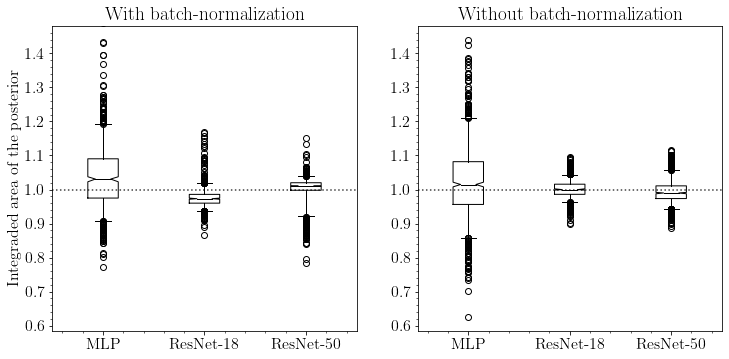

In [12]:
is_out_of_distribution(stellar_density)

Probably out-of-distribution


That means, if the tested observable was truly the observed data, then this result would be indicative of model misspecification under the assumption that the posterior is correctly modelled. In principle, based on the boxplots, we could assign a probability to the observable whether the observable is an out of distribution sample. Nevertheless, it should be noted that passing the test does *not* neccessarily mean that the observable is *not* an out of distribution. It is simply possible that the ratio estimator nicely interpolated in the regime of the specified observable.